In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    # get k'th subgroup in test, others in train
    # ***************************************************
    idx_tr = (np.delete(k_indices, k, 0)).flatten()
    idx_te = k_indices[k]
    x_tr, y_tr = x[idx_tr], y[idx_tr]
    x_te, y_te = x[idx_te], y[idx_te]
    # ***************************************************
    # form data with polynomial degree
    # ***************************************************
    x_poly_tr = build_poly(x_tr, degree)   
    x_poly_te = build_poly(x_te, degree)
    # ***************************************************
    # ridge regression:
    # ***************************************************
    loss_tr, ws = ridge_regression(y_tr, x_poly_tr, lambda_)
    # ***************************************************
    # calculate the loss for train and test data
    # ***************************************************
    loss_te = compute_mse(y_te, x_poly_te, ws) + lambda_*ws@ws
    return loss_tr, loss_te

Ideal lambda is 0.041753189365604


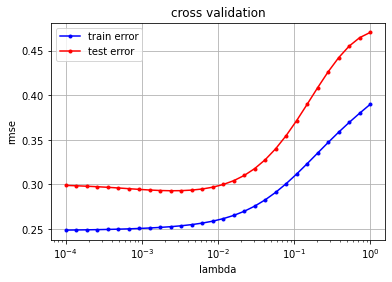

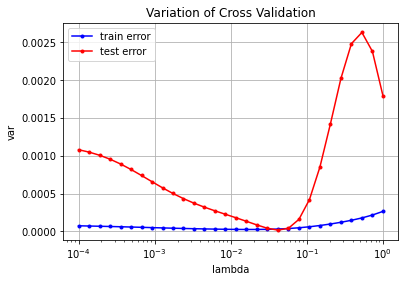

In [5]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    var_tr = []
    var_te = []
    # ***************************************************
    # cross validation:
    # ***************************************************  
    for lambda_ in lambdas:
        k_indices = build_k_indices(y, k_fold, seed)
        loss_ave_tr = []
        loss_ave_te = []
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            loss_ave_tr.append(np.sqrt(2*loss_tr))
            loss_ave_te.append(np.sqrt(2*loss_te))
        rmse_tr.append(np.mean(loss_ave_tr))
        var_tr.append(np.var(loss_ave_tr))
        rmse_te.append(np.mean(loss_ave_te))
        var_te.append(np.var(loss_ave_te))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    plt.figure()
    cross_validation_visualization(lambdas, var_tr, var_te)
    plt.title('Variation of Cross Validation')
    plt.ylabel('var')
    print("Ideal lambda is "+str(lambdas[np.argmin(var_te)]))

cross_validation_demo()

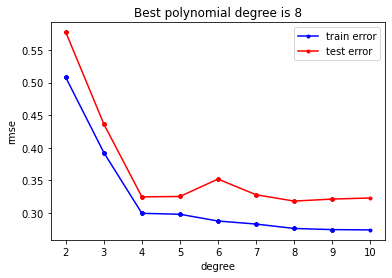

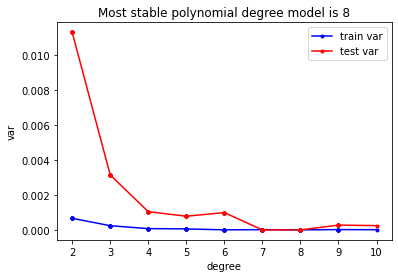

In [6]:
seed = 1
degrees = np.linspace(2,10,dtype=int)
k_fold = 4
lambda_ = 0.041753189365604
# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)
# define lists to store the loss of training data and test data
rmse_tr = []
rmse_te = []
var_tr = []
var_te = []
# ***************************************************
# cross validation:
# ***************************************************  
for degree in degrees:
    k_indices = build_k_indices(y, k_fold, seed)
    loss_ave_tr = []
    loss_ave_te = []
    for k in range(k_fold):
        loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
        loss_ave_tr.append(np.sqrt(2*loss_tr))
        loss_ave_te.append(np.sqrt(2*loss_te))
    rmse_tr.append(np.mean(loss_ave_tr))
    var_tr.append(np.var(loss_ave_tr))
    rmse_te.append(np.mean(loss_ave_te))
    var_te.append(np.var(loss_ave_te))

# plot
plt.figure()
plt.plot(degrees, rmse_tr, marker=".", color='b', label='train error')
plt.plot(degrees, rmse_te, marker=".", color='r', label='test error')
plt.title('Best polynomial degree is '+str(degrees[np.argmin(rmse_te)]))
plt.xlabel('degree')
plt.ylabel('rmse')
plt.legend(['train error', 'test error'])
plt.figure()
plt.plot(degrees, var_tr, marker=".", color='b', label='train error')
plt.plot(degrees, var_te, marker=".", color='r', label='test error')
plt.title('Most stable polynomial degree model is '+str(degrees[np.argmin(var_te)]))
plt.xlabel('degree')
plt.ylabel('var')
plt.legend(['train var', 'test var'])

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

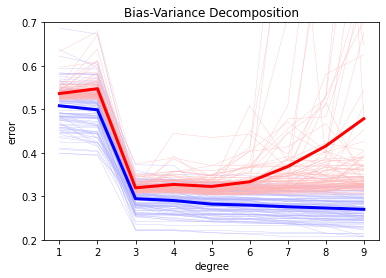

In [7]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # ***************************************************
        # split data with a specific seed
        # ***************************************************
        x_tr, y_tr, x_te, y_te = split_data(x, y, ratio_train, seed)
        # ***************************************************
        # bias_variance_decomposition
        # ***************************************************
        for degree in degrees:
            x_poly_tr = build_poly(x_tr, degree)   
            x_poly_te = build_poly(x_te, degree)
            mse, ws = least_squares(y_tr, x_poly_tr)
            rmse_tr[index_seed,degree-1] = np.sqrt(2*mse)
            rmse_te[index_seed,degree-1] = np.sqrt(2*compute_mse(y_te, x_poly_te, ws))
    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo()

(9, 30)


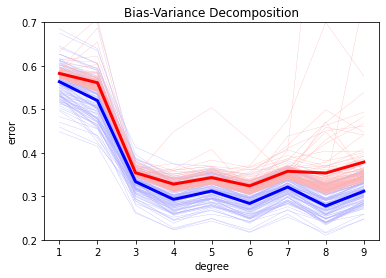

In [8]:
def bias_variance_ridge_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    lambdas = np.logspace(-4, 0, 30)
    k_fold = 4
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees), len(lambdas)))
    rmse_te = np.empty((len(seeds), len(degrees), len(lambdas)))
    var_tr = np.empty((len(seeds), len(degrees), len(lambdas)))
    var_te = np.empty((len(seeds), len(degrees), len(lambdas)))
    
    # Find optimal lambda for each degree
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # ***************************************************
        # split data with a specific seed
        # ***************************************************
        k_indices = build_k_indices(y, k_fold, seed)
        # ***************************************************
        # bias_variance_decomposition
        # ***************************************************
        for i_degree,degree in enumerate(degrees):
            for i_lambda,lambda_ in enumerate(lambdas):
                loss_ave_tr = []
                loss_ave_te = []
                for k in range(k_fold):
                    loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
                    loss_ave_te.append(np.sqrt(2*loss_te))
                var_te[index_seed,i_degree,i_lambda] = np.var(loss_ave_te)
    
    # choose ideal lambda for each degree
    mean_degree_lambda = np.mean(var_te, axis=0)
    print(mean_degree_lambda.shape)
    idx_lambda_min_te = np.argmin(mean_degree_lambda, axis=1)
    lambdas_s = lambdas[idx_lambda_min_te]
    
    # Find optimal model
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # ***************************************************
        # split data with a specific seed
        # ***************************************************
        x_tr, y_tr, x_te, y_te = split_data(x, y, ratio_train, seed)
        # ***************************************************
        # bias_variance_decomposition
        # ***************************************************
        for i_degree,degree in enumerate(degrees):
            x_poly_tr = build_poly(x_tr, degree)   
            x_poly_te = build_poly(x_te, degree)
            mse, ws = ridge_regression(y_tr, x_poly_tr, lambdas_s[i_degree])
            rmse_tr[index_seed,i_degree] = np.sqrt(2*mse)
            rmse_te[index_seed,i_degree] = np.sqrt(2*(compute_mse(y_te, x_poly_te, ws) + lambdas_s[i_degree]*ws@ws))
    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_ridge_demo()